# Cluster Analysis

Methods Implemented:
- K Means
- Hierarchial Clustering
- Birch Clustering
- Agglomerative clustering
- DBSCAN
- OPTICS
- HDBSCAN

Feature Extraction Using a combined action:
- Sequence K-Mers
- Pseudo Amino Acid Composition (PAAC)
    That Considers physicochemical properties:
    - Hydrophobicity
    - Hydrophilicity
    - Mass


Implements multiple clustering algorithms:

- KMeans Clustering: Partitions data into k clusters by minimizing the variance within each cluster.
- Agglomerative Clustering: Hierarchical clustering method that builds nested clusters by merging or splitting them successively.
- DBSCAN Clustering: Density-based clustering algorithm that groups together points that are closely packed together.
- OPTICS Clustering: Similar to DBSCAN but can identify clusters of varying densities.
- BIRCH Clustering: Hierarchical clustering algorithm that builds a tree structure for clustering large datasets.
- General Linkage Hierarchical Clustering: Similar to BIRCH but used a traditional linkage sampling approach
- Gaussian Mixture Model: Probabilistic model that assumes all data points are generated from a mixture of several Gaussian distributions.

### Code to take the fasta file and tidy-up the headers
- Renaming the fasta headers as sample_XX, starting from an anchor seq sample_0 (first seq)
And the storing the new filtered fasta file for the usage in the code.

In [1]:
# Function to read FASTA formatted file and return sequences as a list
def read_fasta(file_path):
    """
    Reads a FASTA file and returns a dictionary with sample names as keys and sequences as values.
    """
    with open(file_path, 'r') as file:
        fasta_data = file.read().split(">")[1:]
    sequences = {}
    for lines in fasta_data:
        header_key = f"Sample_{len(sequences)}"
        seq_value = lines.split("\n", 1)[1].replace("\n", "").strip()
        sequences[header_key] = seq_value
    return sequences
    
#Replace with your FASTA file path and output file path
# Define Fasta File Path
fasta_file_path = "CLGIPL-5000-temp02.fa"
output_file_path = "merged_fasta.fa"

# Read the FASTA file and store the sequences in a dictionary
reader_obj = read_fasta(fasta_file_path)
reader_obj_values = list(reader_obj.values())

# Write the reader_obj_values sequences to a new FASTA file
with open(output_file_path, 'w') as output_file:
    for idx, seq in enumerate(reader_obj_values):
        output_file.write(f">Sample_{idx}\n{seq}\n")


### Module Imports
Import all the modules used in this script

In [8]:
import os
import hdbscan
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, Birch, AgglomerativeClustering, OPTICS
from sklearn.metrics import silhouette_score, pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### K-mer feature
- Extracting the Sequence K-mers for seq features

In [3]:
# K-mer feature extraction
def kmer_count(sequence, k=3):
    kmer_dict = {}
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        kmer_dict[kmer] = kmer_dict.get(kmer, 0) + 1
    return kmer_dict

def generate_kmer_matrix(sequences, k=3):
    kmer_matrices = []
    for sequence in sequences:
        kmer_matrices.append(kmer_count(sequence, k))
    return kmer_matrices

### Pseudo Amino Acid Composition Feature Extraction
- Extract feature vectors based on PAAC and calculate the theta values accordingly

In [4]:
# PAAC feature extraction
class PseudoAminoAcidComposition:
    def __init__(self, fasta_data, lambda_=30, w=0.05):
        self.lambda_ = lambda_
        self.w = w
        self.physicochemical_properties = {
            'hydrophobicity': {'A': 0.62, 'C': 0.29, 'D': -0.90, 'E': -0.74, 'F': 1.19, 'G': 0.48, 'H': -0.40, 'I': 1.38, 'K': -1.50, 'L': 1.06, 'M': 0.64, 'N': -0.78, 'P': 0.12, 'Q': -0.85, 'R': -2.53, 'S': -0.18, 'T': -0.05, 'V': 1.08, 'W': 0.81, 'Y': 0.26},
            'hydrophilicity': {'A': -0.5, 'C': -1.0, 'D': 3.0, 'E': 3.0, 'F': -2.5, 'G': 0.0, 'H': -0.5, 'I': -1.8, 'K': 3.0, 'L': -1.8, 'M': -1.3, 'N': 0.2, 'P': 0.0, 'Q': 0.2, 'R': 3.0, 'S': 0.3, 'T': -0.4, 'V': -1.5, 'W': -3.4, 'Y': -2.3},
            'mass': {'A': 15.0, 'C': 47.0, 'D': 59.0, 'E': 73.0, 'F': 91.0, 'G': 1.0, 'H': 82.0, 'I': 57.0, 'K': 73.0, 'L': 57.0, 'M': 75.0, 'N': 58.0, 'P': 42.0, 'Q': 72.0, 'R': 101.0, 'S': 31.0, 'T': 45.0, 'V': 43.0, 'W': 130.0, 'Y': 107.0}
        }
        self.amino_acids = {idx + 1: aa for idx, aa in enumerate("ACDEFGHIKLMNPQRSTVWY")}
        self.collect_features(fasta_data)

    def collect_features(self, fasta_data):
        features = []
        features.append(['#'] + list(self.amino_acids.values()) + [f'λ{i}' for i in range(1, self.lambda_ + 1)])
        for i in range(0, len(fasta_data), 2):
            accession = fasta_data[i].strip()
            sequence = fasta_data[i + 1].strip()
            if len(sequence) < self.lambda_:
                print(f"Sequence {accession} skipped due to insufficient length.")
                continue
            paac = self.calculate_paac(sequence)
            features.append([accession] + paac)
        self.df = pd.DataFrame(features[1:], columns=features[0])

    def calculate_paac(self, sequence):
        lower_theta = self.calculate_lower_theta(sequence)
        denominator = 1 + (self.w * sum(lower_theta.values()))
        paac = []
        for i in range(1, 21 + self.lambda_):
            if i <= 20:
                numerator = sequence.count(self.amino_acids[i]) / len(sequence)
                paac.append(numerator / denominator)
            else:
                numerator = self.w * lower_theta[i - 20]
                paac.append(numerator / denominator)
        return paac

    def calculate_lower_theta(self, sequence):
        lower_theta = {}
        for i in range(1, self.lambda_ + 1):
            if len(sequence) <= i:
                lower_theta[i] = 0
            else:
                lower_theta[i] = (1 / (len(sequence) - i)) * self.calculate_upper_theta(sequence, i)
        return lower_theta

    def calculate_upper_theta(self, sequence, i):
        upper_theta = []
        for j in range(len(sequence) - i):
            diff = [
                (self.physicochemical_properties[prop][sequence[j]] -
                 self.physicochemical_properties[prop][sequence[j + i]]) ** 2
                for prop in self.physicochemical_properties
            ]
            upper_theta.append(sum(diff) / len(self.physicochemical_properties))
        return sum(upper_theta)

### Combining the two feature sets
- K-mers and PAAC for better feature representation.

In [5]:
# Load sequences
def load_sequences(file_path):
    return [str(record.seq) for record in SeqIO.parse(file_path, "fasta")]

# Combine K-mer and PAAC features
def combine_features(sequences, k=3, lambda_=30, w=0.05):
    kmer_features = generate_kmer_matrix(sequences, k)
    
    fasta_data = []
    for idx, seq in enumerate(sequences):
        fasta_data.extend([f">seq_{idx}", seq])
    
    paac = PseudoAminoAcidComposition(fasta_data, lambda_, w)
    paac_features = paac.df.iloc[:, 1:].values.tolist()
    
    combined_features = []
    max_length = max(len(list(kmer.values()) + paac) for kmer, paac in zip(kmer_features, paac_features))
    
    for kmer, paac in zip(kmer_features, paac_features):
        feature = list(kmer.values()) + paac
        # Pad with zeros if necessary
        feature += [0] * (max_length - len(feature))
        combined_features.append(feature)
    return np.array(combined_features, dtype=float)

### Define Clustering functions
- Simple clustering functions based on sklearn and scipy for clustering based on the combined features extracted.
Includes:
- Kmeans
- DBSCAN
- Linkage Hierarchial
- Birch
- Agglomerative
- Optics
- HDBSCAN

And evaluating their metrics (Silhouette Score - Intrinsic Score) 
Silhouette Coefficient (SC): Measures how similar an object is to its own cluster compared to other clusters.

In [6]:
# Clustering functions
def kmeans_clustering(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    return labels

def dbscan_clustering(features, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(features)
    return labels

def hierarchical_clustering(features, n_clusters):
    linkage_matrix = linkage(features, method='ward')
    labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    return labels

def birch_clustering(features, n_clusters):
    birch = Birch(n_clusters=n_clusters)
    labels = birch.fit_predict(features)
    return labels

def agglomerative_clustering(features, n_clusters):
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agglomerative.fit_predict(features)
    return labels

def optics_clustering(features, min_samples, xi, min_cluster_size):
    optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)
    labels = optics.fit_predict(features)
    return labels

def hdbscan_clustering(features, min_cluster_size, min_samples):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    labels = clusterer.fit_predict(features)
    
    # Count the occurrences of each label, excluding noise points (-1)
    unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)
    
    # Sort clusters by size in descending order
    sorted_clusters = sorted(zip(unique_labels, counts), key=lambda x: x[1], reverse=True)
    
    # Select the top 10 clusters (or all if there are fewer than 10)
    top_clusters = sorted_clusters[:min(10, len(sorted_clusters))]
    top_cluster_labels = [label for label, _ in top_clusters]
    
    # Create a new label array with only the top clusters
    new_labels = np.full_like(labels, -1)
    for new_label, (old_label, _) in enumerate(top_clusters):
        new_labels[labels == old_label] = new_label
    
    return new_labels

# Evaluation function
def evaluate_clustering(features, labels):
    if len(set(labels)) > 1 and -1 not in set(labels):
        return silhouette_score(features, labels)
    else:
        return -1  # Invalid clustering (single cluster or noise)

# Main clustering function
def cluster_sequences(sequences, k=3, lambda_=30, w=0.05, n_clusters=10):
    # Extract combined features
    features = combine_features(sequences, k, lambda_, w)
    
    # Normalize features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)
    
    # Dimensionality reduction
    pca = PCA(n_components=min(50, len(normalized_features[0])))
    reduced_features = pca.fit_transform(normalized_features)
    
    # Perform clustering
    kmeans_labels = kmeans_clustering(reduced_features, n_clusters)
    dbscan_labels = dbscan_clustering(reduced_features, eps=0.5, min_samples=5)
    hierarchical_labels = hierarchical_clustering(reduced_features, n_clusters)
    birch_labels = birch_clustering(reduced_features, n_clusters)
    agglomerative_labels = agglomerative_clustering(reduced_features, n_clusters)
    optics_labels = optics_clustering(reduced_features, min_samples=5, xi=0.05, min_cluster_size=int(0.05 * len(sequences)))
    hdbscan_labels = hdbscan_clustering(reduced_features, min_cluster_size=5, min_samples=5)
    
    # Evaluate clustering results
    kmeans_score = evaluate_clustering(reduced_features, kmeans_labels)
    dbscan_score = evaluate_clustering(reduced_features, dbscan_labels)
    hierarchical_score = evaluate_clustering(reduced_features, hierarchical_labels)
    birch_score = evaluate_clustering(reduced_features, birch_labels)
    agglomerative_score = evaluate_clustering(reduced_features, agglomerative_labels)
    optics_score = evaluate_clustering(reduced_features, optics_labels)
    hdbscan_score = evaluate_clustering(reduced_features, hdbscan_labels)
    
    print(f"K-means Silhouette Score: {kmeans_score:.3f}")
    print(f"DBSCAN Silhouette Score: {dbscan_score:.3f}")
    print(f"Hierarchical Silhouette Score: {hierarchical_score:.3f}")
    print(f"Birch Silhouette Score: {birch_score:.3f}")
    print(f"Agglomerative Silhouette Score: {agglomerative_score:.3f}")
    print(f"OPTICS Silhouette Score: {optics_score:.3f}")
    print(f"HDBSCAN Silhouette Score: {hdbscan_score:.3f}")
    
    # Return the best clustering result
    all_labels = [kmeans_labels, dbscan_labels, hierarchical_labels, birch_labels, agglomerative_labels, optics_labels, hdbscan_labels]
    best_labels = max(all_labels, key=lambda x: evaluate_clustering(reduced_features, x))
    return best_labels, reduced_features


### Plotting
Creating the plots for the clusters and visualizing them using PCA.

K-means Silhouette Score: 0.137
DBSCAN Silhouette Score: -1.000
Hierarchical Silhouette Score: 0.127
Birch Silhouette Score: 0.103
Agglomerative Silhouette Score: 0.127
OPTICS Silhouette Score: -1.000
HDBSCAN Silhouette Score: -1.000


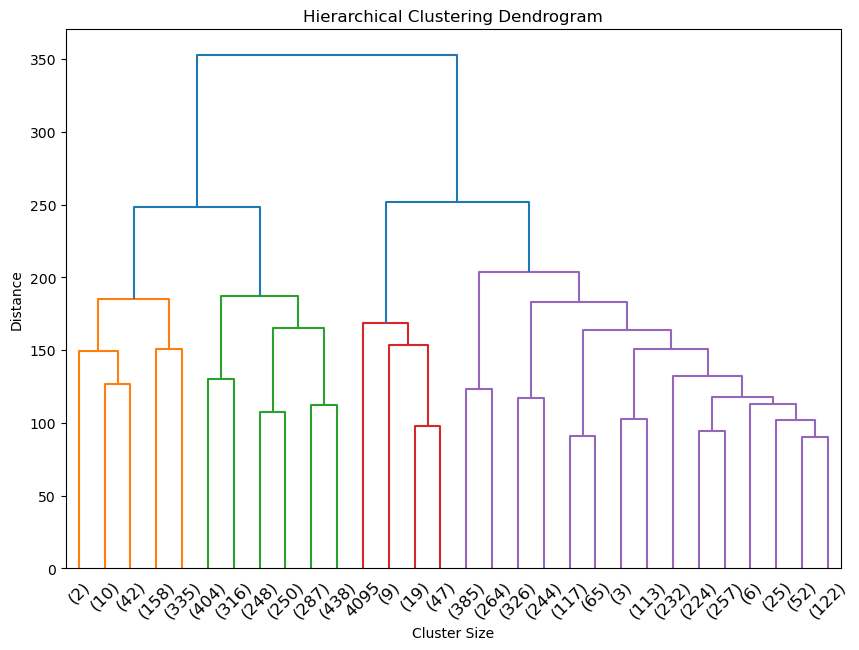

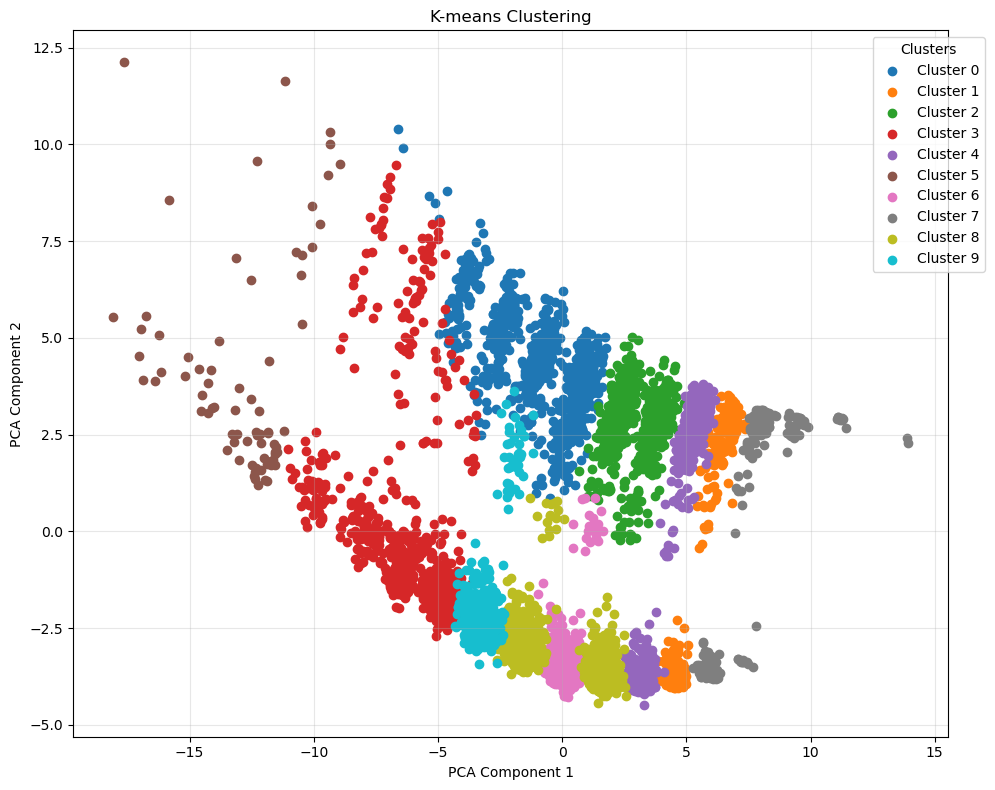

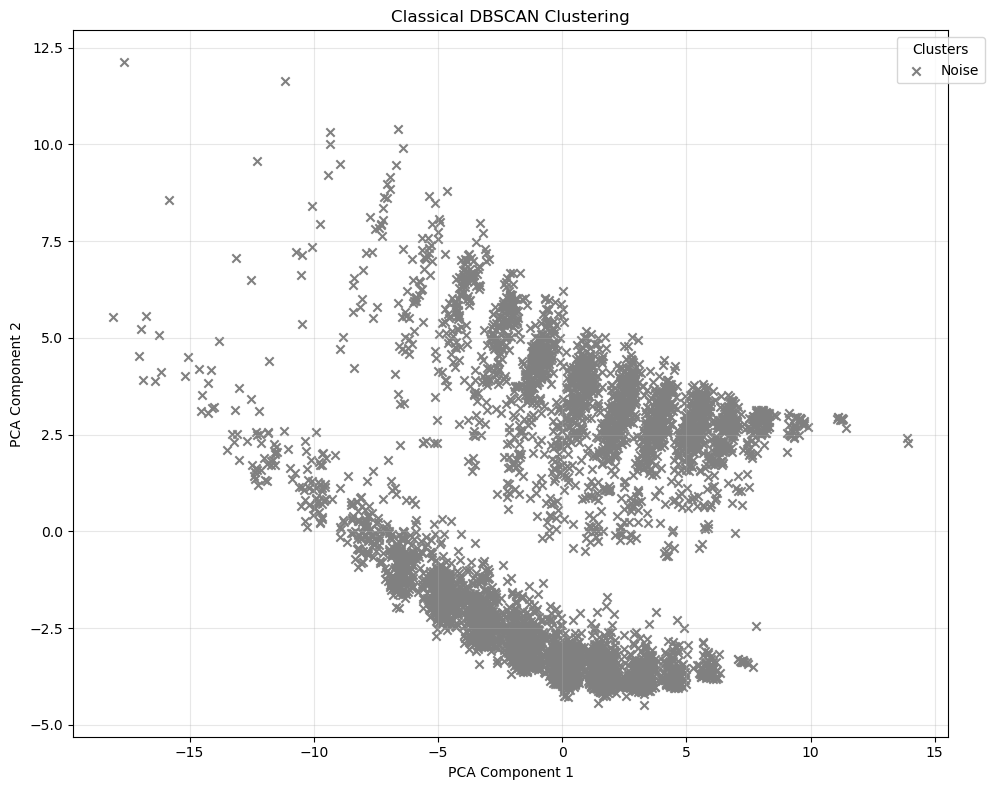

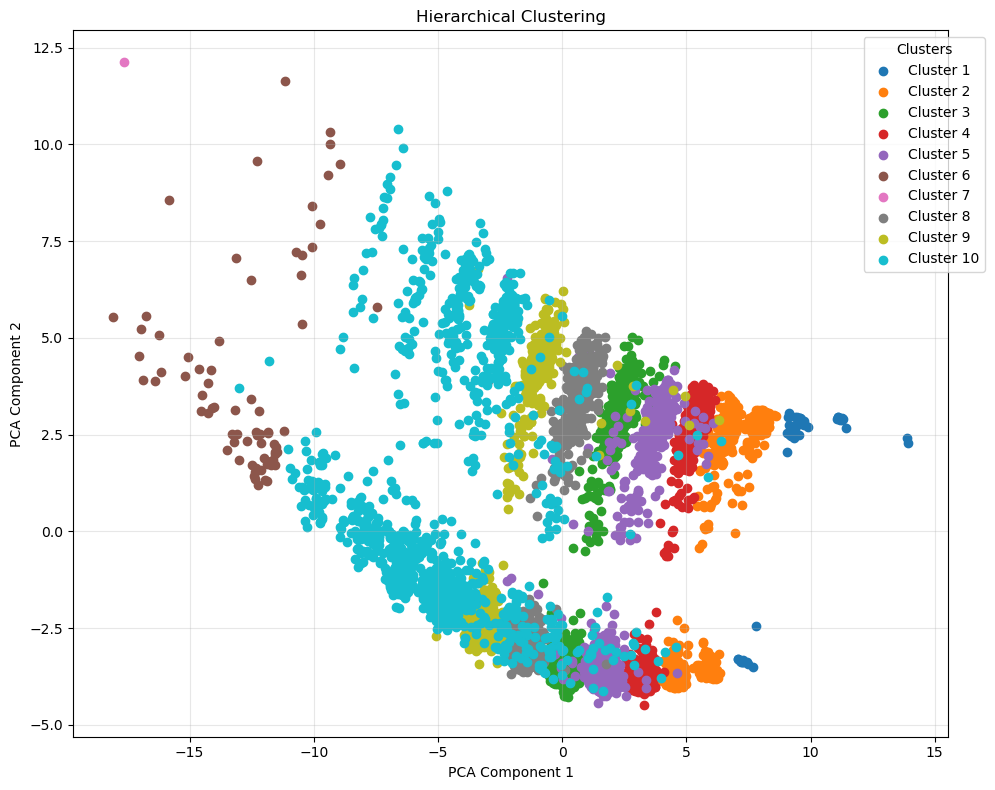

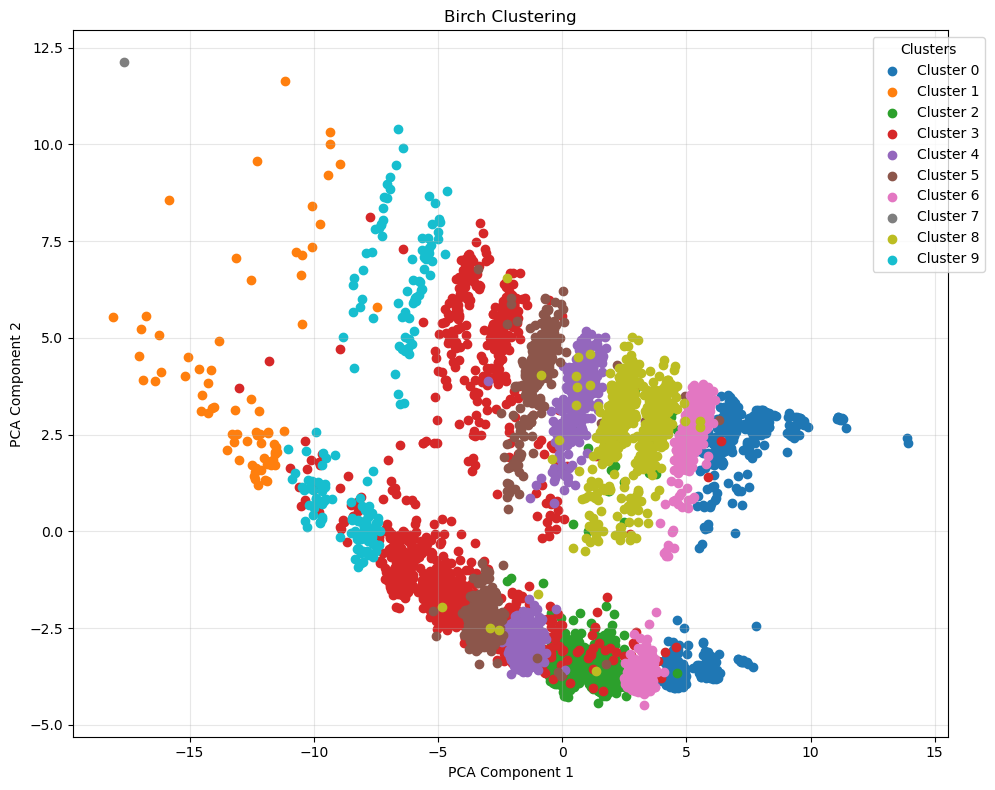

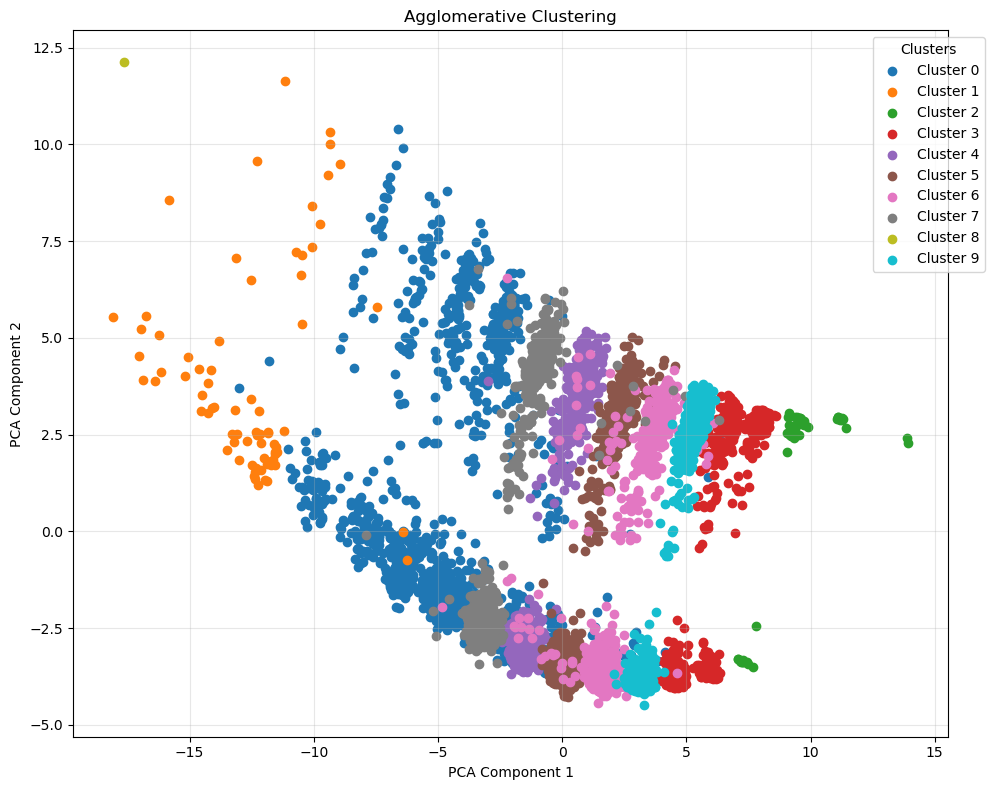

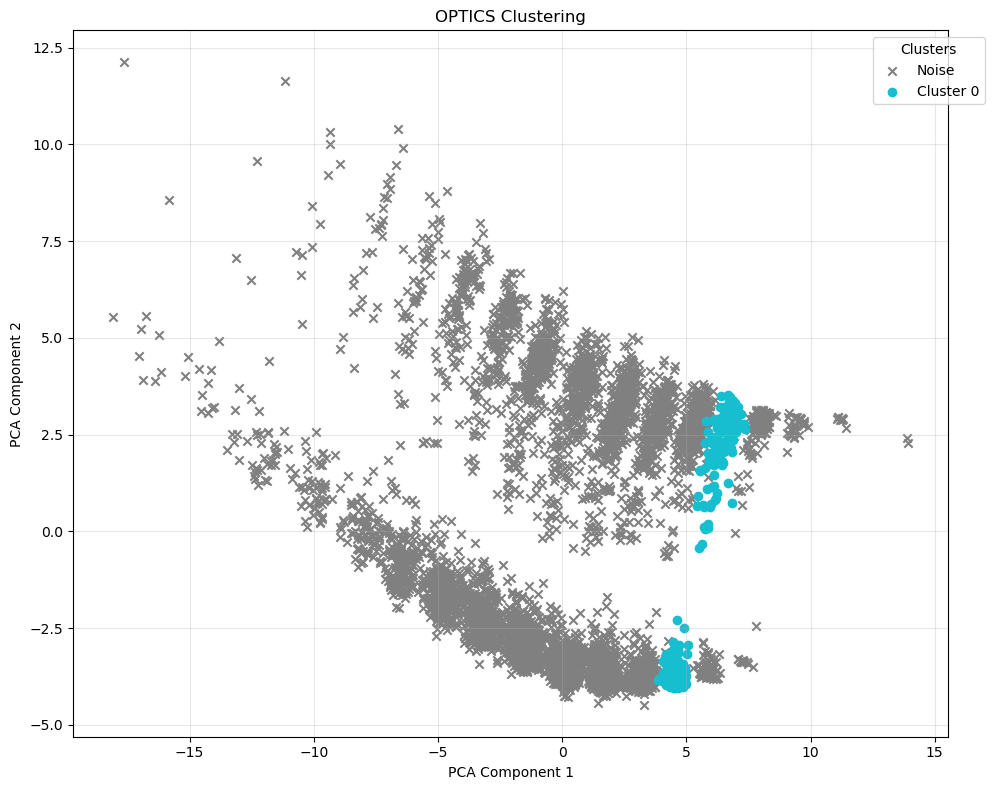

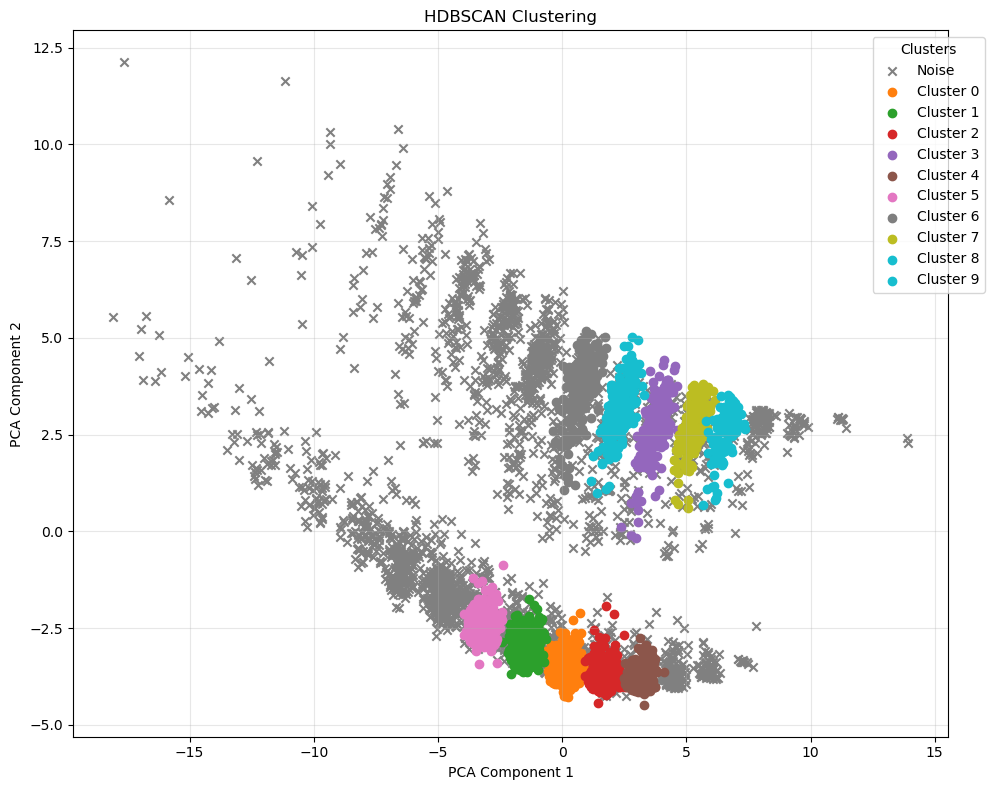

In [7]:
def plot_clusters(features, labels, title):
    # Use PCA to reduce features to 2 dimensions for plotting
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)

    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

    plt.figure(figsize=(10, 8))
    for label, color in zip(unique_labels, colors):
        if label == -1:  # Noise in DBSCAN or HDBSCAN
            plt.scatter(
                pca_features[labels == label, 0],
                pca_features[labels == label, 1],
                c='gray',
                marker='x',
                label='Noise'
            )
        else:
            plt.scatter(
                pca_features[labels == label, 0],
                pca_features[labels == label, 1],
                c=[color],
                label=f'Cluster {label}'
            )

    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), title="Clusters")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_dendrogram(linkage_matrix, title):
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, truncate_mode='lastp', p=30, show_leaf_counts=True, leaf_rotation=45, leaf_font_size=12)
    plt.title(title)
    plt.xlabel('Cluster Size')
    plt.ylabel('Distance')
    plt.show()

def visualize_all_clusters(features, labels_dict):
    for method, labels in labels_dict.items():
        plot_clusters(features, labels, f"{method} Clustering")

# Example usage in your code:

file_path = "merged_fasta.fa"
sequences = load_sequences(file_path)
best_labels, reduced_features = cluster_sequences(sequences)
# Generate labels_dict after clustering
labels_dict = {
    "K-means": kmeans_clustering(reduced_features, n_clusters=10),
    "Classical DBSCAN": dbscan_clustering(reduced_features, eps=0.5, min_samples=5),
    "Hierarchical": hierarchical_clustering(reduced_features, n_clusters=10),
    "Birch": birch_clustering(reduced_features, n_clusters=10),
    "Agglomerative": agglomerative_clustering(reduced_features, n_clusters=10),
    "OPTICS": optics_clustering(reduced_features, min_samples=5, xi=0.05, min_cluster_size=int(0.05 * len(sequences))),
    "HDBSCAN": hdbscan_clustering(reduced_features, min_cluster_size=5, min_samples=5),
}
plot_dendrogram(linkage(reduced_features, method='ward'), "Hierarchical Clustering Dendrogram")
# Visualize all clustering results
visualize_all_clusters(reduced_features, labels_dict)

### Best performed clustering:

- K-Means Clustering
- HDBSCAN Clustering
- Birch Clustering
- Agglomerate Clustering
- Hierarchial Clustering

So saving the clusters of their sequences accordingly. Saving all the files, but use the cluster files according to the best cluster capture.

#### Saving all the cluster sequences from each cluster method seperately in different cluster files and folders according to their method of clustering



In [27]:
# Save clustered sequences to files
def save_cluster_sequences(sequences, labels_dict, output_dir, original_headers):
    for method_name, labels in labels_dict.items():
        # Create method-specific directory
        method_dir = os.path.join(output_dir, method_name)
        os.makedirs(method_dir, exist_ok=True)
        
        # Group sequences by cluster
        clusters = {}
        for seq, label, header in zip(sequences, labels, original_headers):
            if label not in clusters:
                clusters[label] = []
            clusters[label].append((seq, header))
        
        # Save sequences for each cluster
        for label, cluster_seqs in clusters.items():
            cluster_file = os.path.join(method_dir, f"cluster_{label}.fasta")
            with open(cluster_file, 'w') as f:
                for seq, header in cluster_seqs:
                    f.write(f"{header}\n{seq}\n")
        
        print(f"Saved {len(clusters)} clusters for {method_name} in {method_dir}")

# Use the function with the labels dictionary
labels_dict = {
    "K-means": kmeans_clustering(reduced_features, n_clusters=10),
    "Classical DBSCAN": dbscan_clustering(reduced_features, eps=0.5, min_samples=5),
    "Hierarchical": hierarchical_clustering(reduced_features, n_clusters=10),
    "Birch": birch_clustering(reduced_features, n_clusters=10),
    "Agglomerative": agglomerative_clustering(reduced_features, n_clusters=10),
    "OPTICS": optics_clustering(reduced_features, min_samples=5, xi=0.05, min_cluster_size=int(0.05 * len(sequences))),
    "HDBSCAN": hdbscan_clustering(reduced_features, min_cluster_size=5, min_samples=5)
}

# Assuming you have a list of original headers
original_headers = [f">Sample_{i}" for i in range(len(sequences))]

save_cluster_sequences(sequences, labels_dict, "output_clusters", original_headers)

Saved 10 clusters for K-means in output_clusters/K-means
Saved 1 clusters for Classical DBSCAN in output_clusters/Classical DBSCAN
Saved 10 clusters for Hierarchical in output_clusters/Hierarchical
Saved 10 clusters for Birch in output_clusters/Birch
Saved 10 clusters for Agglomerative in output_clusters/Agglomerative
Saved 2 clusters for OPTICS in output_clusters/OPTICS
Saved 11 clusters for HDBSCAN in output_clusters/HDBSCAN


## Finding the Medoid of the clusters for the best represented sequence in the cluster (Minimal Center): 
K-Means selected because of better clustering and lower outlier noise.

- Centroid represents the geometric center of a cluster, calculated as the average of all data points within that cluster. (May not be an actual data point)
- Whereas, Medoid is a data point within the cluster that is considered the most centrally located, minimizing the sum of distances to all other points in the cluster. (Best represented sequence)


In [ ]:
# Compute the medoid
def compute_medoid(cluster_data):
    distances = pairwise_distances(cluster_data)  # Compute pairwise distances
    medoid_index = np.argmin(distances.sum(axis=0))  # Find the point with the smallest total distance
    return medoid_index  # Return the index of the medoid

# Function to compute medoids and map back to original data
def medoid_seq_with_data(features, labels, sequences):
    unique_labels = np.unique(labels)
    medoids = {}
    medoid_sequences = {}
    
    for label in unique_labels:
        if label == -1:  # Skip noise points - as they don't have a cluster
            continue
        # Get the indices of points in the current cluster
        cluster_indices = np.where(labels == label)[0]
        cluster_points = features[cluster_indices]
        
        # Get the medoid index within the cluster
        medoid_index_within_cluster = compute_medoid(cluster_points)
        medoid_index = cluster_indices[medoid_index_within_cluster]  # Map back to the original index
        
        # Save the medoid feature and corresponding sequence
        medoids[label] = features[medoid_index]
        medoid_sequences[label] = sequences[medoid_index]
    
    return medoids, medoid_sequences

medoids, medoid_sequences = medoid_seq_with_data(reduced_features, labels_dict["K-means"], sequences)


In [ ]:
# Print medoid sequences
print("\nMedoid Sequences:")
for cluster_id, medoid_sequence in medoid_sequences.items():
    print(f"Cluster {cluster_id}: {medoid_sequence}")
    
# Save medoid sequences to a file in a new folder called representative_seq_mediods
os.makedirs("representative_sequences", exist_ok=True)
with open("representative_sequences/medoid_sequences.fasta", 'w') as f:
    for cluster_id, medoid_sequence in medoid_sequences.items():
        f.write(f">Medoid_Cluster_{cluster_id}\n{medoid_sequence}\n")
print("\nMedoid sequences saved to representative_sequences/medoid_sequences.fasta")